# How to get rid of tiling artifacts

Follow-up tutorial for 

### [Tiling artifacts and trade-offs of feature normalization in the segmentation of large biological images](https://arxiv.org/abs/2503.19545) at ICCV 2025

## I can see tile borders in my stitched predictions ("¬_¬)

Biological images, especially in the case of volumetric imaging, are large. Electron microscopy volumes for connectomics or light sheet microscopy volumes can reach the scale of multiple terabytes. It is routine to work with 10-100 GB images of $∼1000^3$ pixels, which exceed GPU memory.

During training random patches are sampled from the annotated images and combined into a batch. During inference/evaluation, the image is split into a grid of tiles which are processed by the network independently and then stitched back to form the full prediction. Here I refer both to 2D and 3D image patches as tiles. In this setup the size of the tiles is limited from above by GPU memory and from below by the receptive field of the network. Typical tile size is around 96x96x96 - 256x256x256 pixels.

<img src="images/training_pipeline.png" alt="Sliding window inference" align=center style="width: 400px;"/>

Tiling and stitching seem like purely technical steps, however, they can cause artifacts if predictions in neighboring tiles don't match exactly on the border. Sliding window inference is based on the idea that the predictions remain the same no matter how the tiling was made. If there is an overlap between two tiles, then in the overlapping area predictions for the same pixels should **match exactly**. In this case stitcing would be seamless and produce the final prediction as if we had a GPU with infinite memory.

Unfortunately, it's not how it goes in many pipelines. The strength of tiling artifacts varies a lot depending on the specific network and dataset. It can go from barely noticeable to severely detrimental. Unfortunately, even if the artifacts are barely visible, in my experience post-processing algorithms are often very good at noticing these slight but very regular variations. For example, watershed and graph cut-based algorithms tend to make fun square-shaped instances even if the tile border is barely visible. Registration algorithms love to register stitching lines instead of focusing on the real content of the segmentation. Lastly, artifacts often become more pronounced when the network is reused for the data it was not originally trained on. All of this makes putting some effort into achieving seamless stitching well worth it. 




## Causes of tiling artifacts

There are 4 main causes of tiling artifacts:

1) Tile-wise normalization in pre-processing
2) Edge effects in the network predictions
3) Tile-wise feature normalization inside the network
4) Tile-wise normalization in post-processing

Mostly when I bring up tiling artifacts, people who have experience with sliding window inference say that it's all edge effects and I just need to make overlap between tiles larger, so in this tutorial I will cover edge effects as the most widely known and easily solvable reason. 

However, it turns out that feature normalization inside the network causes much worse artifacts which can not be compensated for with simple postprocessing. These artifacts affect the whole tile, not just the edges, and strongly depend on the underlying data, making it hard to trace the source of the issue and debug it. In this tutorial I will mostly focus on the feature normalization.

Finally, I will briefly comment on (1) and (4) - these parts are very diverse and specific to each pipeline, although there are some general rules to follow to achieve seamless final prediction.

## `InstanceNorm` refresher



Neural networks consist of a series of filters with normalization and nonlinearity layers in between. Feature normalization helps to make convergence faster and more stable with respect to training parameters. In most cases it's probably possible to train a network with no normalization layers at all - however, the search for optimal learning rate schedule and other parameters might require much more effort.

 The general formula for the normalization operation with input $x$, output $y$ is:

$$
y = \frac{x-\mu}{\sqrt{\sigma^2 + \epsilon}},
$$
where $\mu$ and $\sigma$ are normalization parameters and $\epsilon$ is a small constant used for numerical stability. Parameters $\mu$ and $\sigma$ can be estimated directly from the input $\mu = \mathrm{E}[x]$ and $\sigma^2 = \mathrm{Var}[x]$, where average can be taken either over each sample independently or over the whole batch. Alternatively, global normalization parameters independent of the current input can be used. A common strategy is to estimate the parameters as a running average over multiple batches: $p_{new} = (1 - momentum) \times p_{old} + momentum \times p_{t}$. The update speed is determined by the $momentum$, set to $0.1$ by default. 

Both during training and during inference $InstanceNorm$ uses statistics of each tile. This means that essentially **each tile's predictions are calculated with different feature normalization parameters**, making seamless stitching impossible. While it's true maths-wise, maybe it's not such a big problem because the statistics of all tiles are roughly the same? Let's look at some data.

## Variability inside the dataset

Here I load and visualize an example dataset.

In [1]:
from bio_monai.data import load_data_config
from no_tiling.data import config_to_dataset
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

In [2]:
cd ..

/g/kreshuk/buglakova/projects/no_tiling_artifacts


In [3]:
config_path = "experiments/em_organoids/setup_01.yaml"
data_config_path = "experiments/em_organoids/data_config_organoids_full.json"

with open(config_path, "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)

data_config = load_data_config(data_config_path)

cols = {"fg": "#66c2a5", "bg": "#8da0cb", "boundaries": "#fc8d62", "extra": "#e78ac3"}
channels = {"fg": 0, "bg": 3, "boundaries": 1, "extra": 2}
full_names = {"fg": "foreground", "bg": "background", "boundaries": "boundaries", "extra": "extracellular"}

Read data config
Read successful


In [4]:
ds = config_to_dataset(config["train"]["dataset"], data_config["full_data"])

Loading dataset:   0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 1/1 [03:56<00:00, 236.11s/it]


In [5]:
data = ds[0]["image"].numpy()[0]
label = ds[0]["label"].numpy().astype(np.uint16)

<Figure size 2000x2000 with 0 Axes>

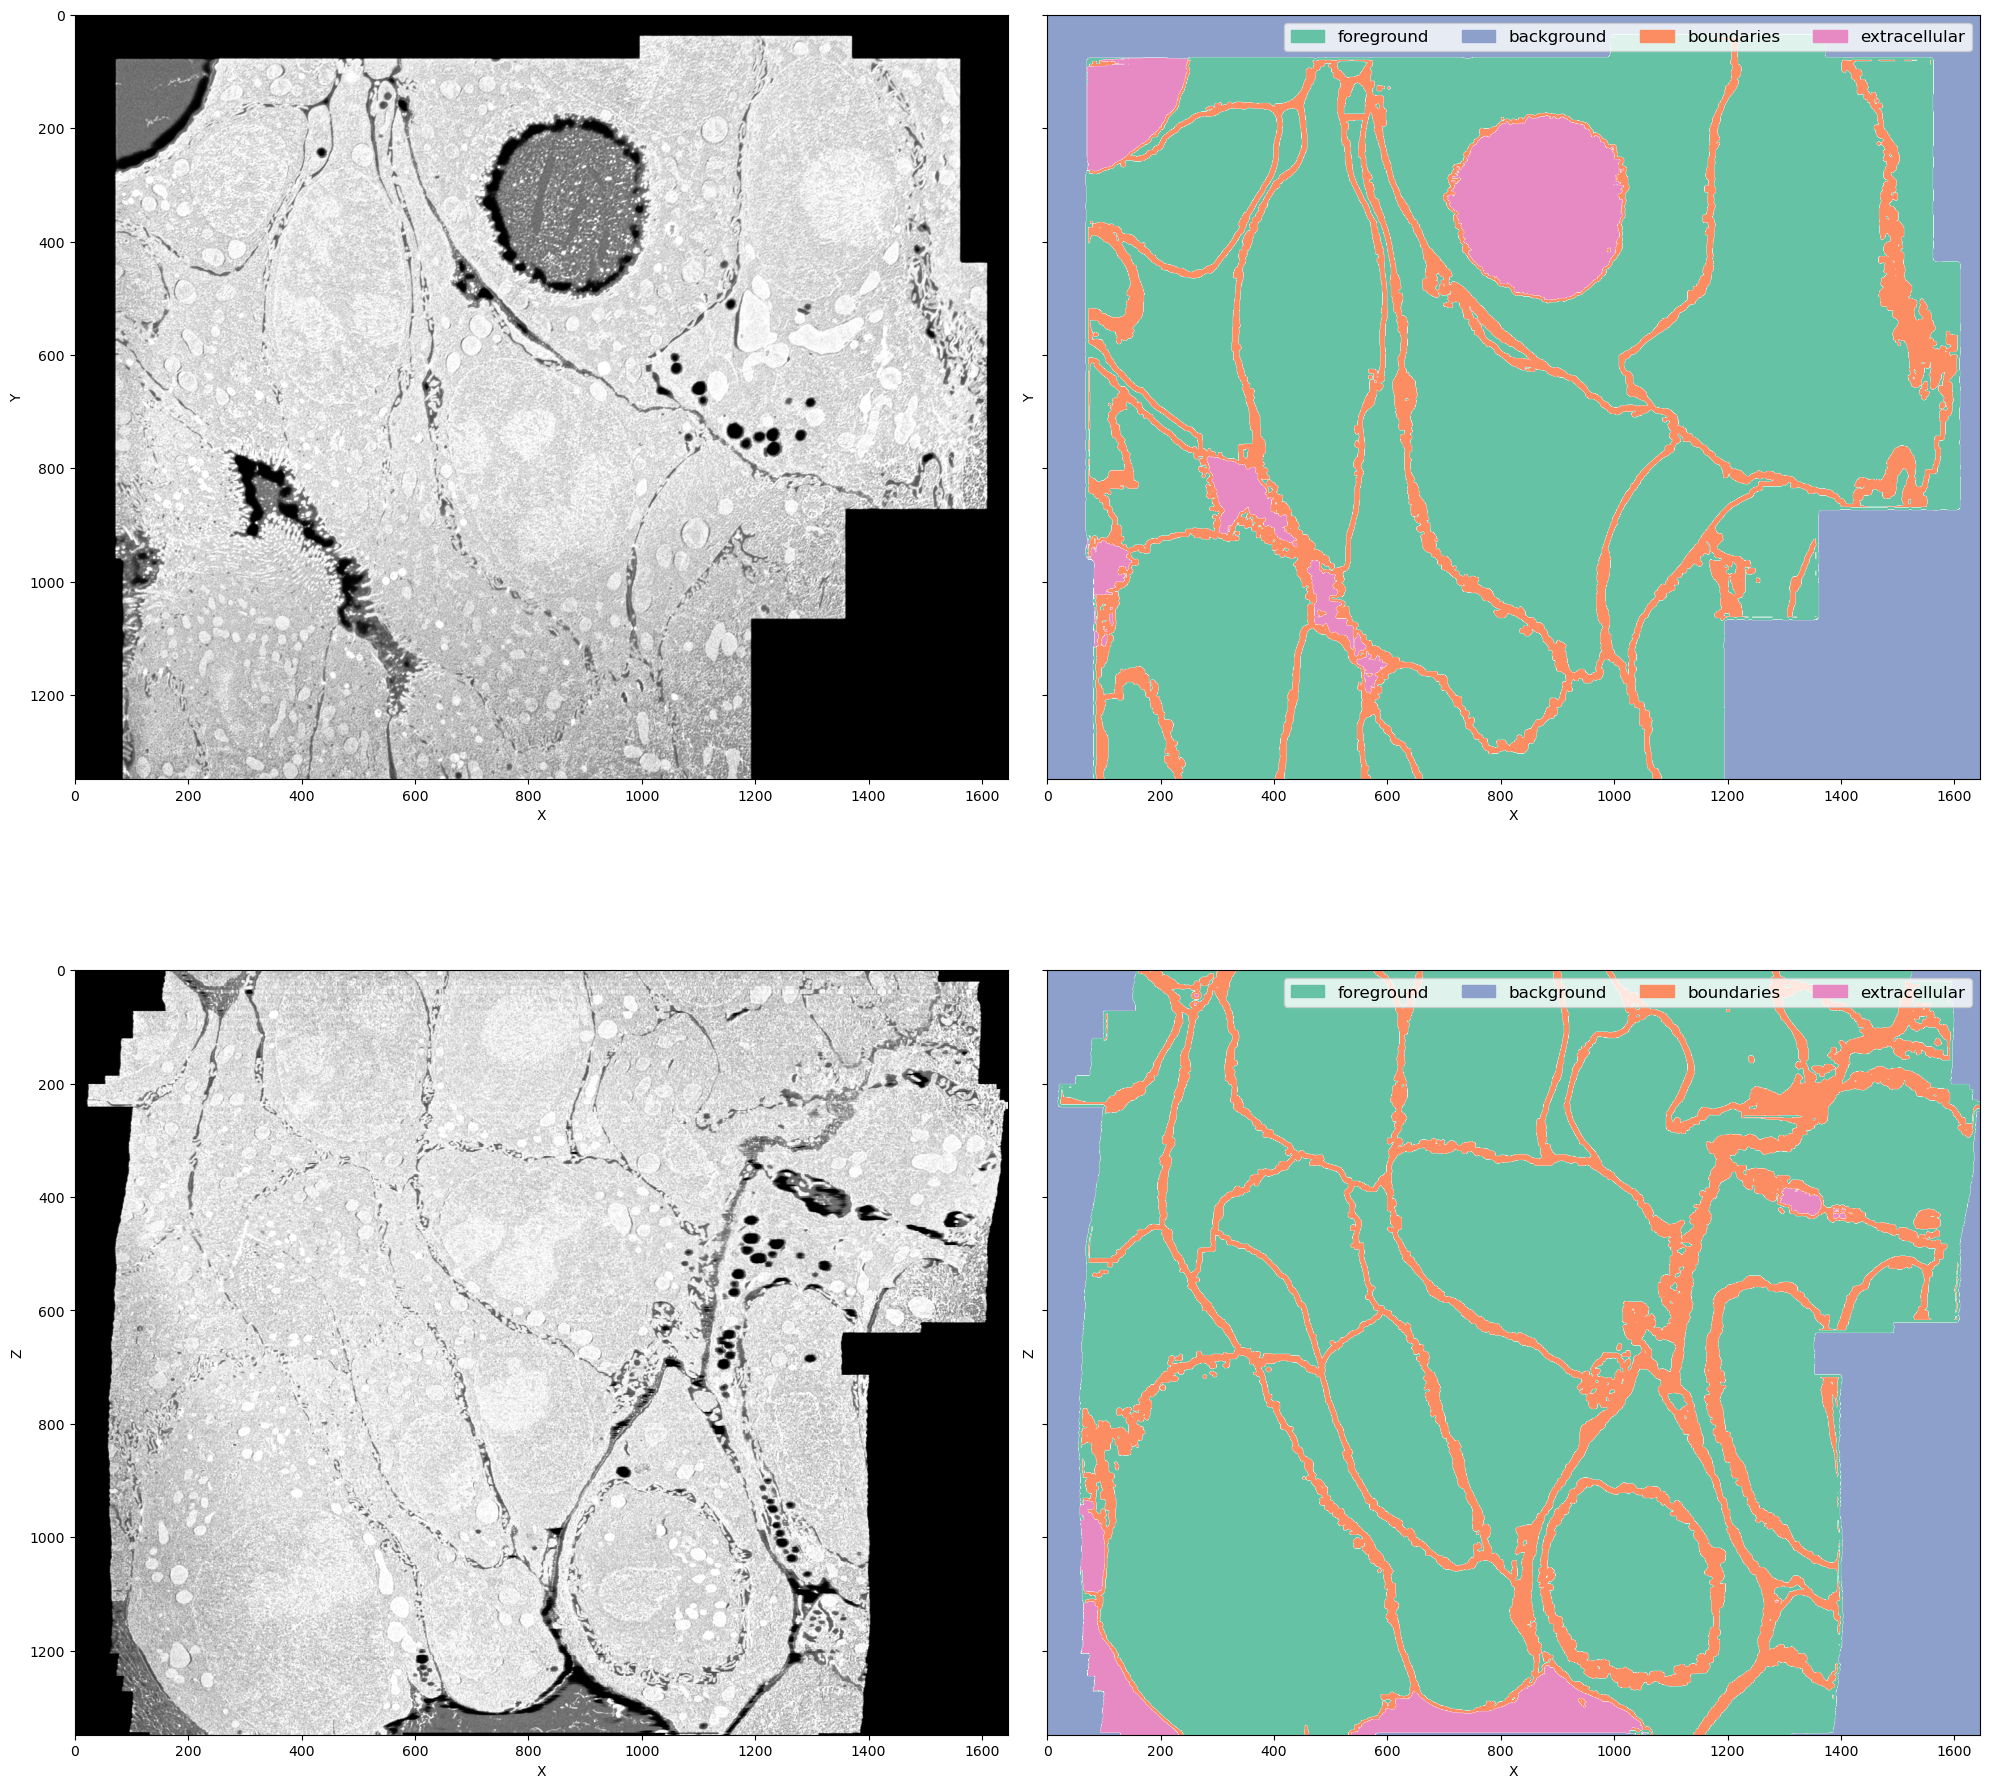

In [6]:
xy_slice_roi = np.s_[500, :, :]
xz_slice_roi = np.s_[:, 750, :]
plt.figure(figsize=(20, 20))

f, ax = plt.subplots(2, 2, sharey=True, figsize=(20, 20))

ax[0, 0].imshow(data[xy_slice_roi], cmap="Greys_r")
ax[0, 0].set_xlabel("X")
ax[0, 0].set_ylabel("Y")

ax[1, 0].imshow(data[xz_slice_roi], cmap="Greys_r")
ax[1, 0].set_xlabel("X")
ax[1, 0].set_ylabel("Z")

legend_patches = []
for name, chan in channels.items():
    cmap = colors.ListedColormap(['white', cols[name]])
    ax[0, 1].imshow(label[chan][xy_slice_roi], label=name, cmap=cmap, alpha=(label[chan][xy_slice_roi] > 0).astype(float))
    legend_patches.append(mpatches.Patch(color=cols[name], label=full_names[name]))

ax[1, 1].legend(handles=legend_patches, fontsize="large", ncol=4)
ax[0, 1].set_xlabel("X")
ax[0, 1].set_ylabel("Y")

legend_patches = []
for name, chan in channels.items():
    cmap = colors.ListedColormap(['white', cols[name]])
    ax[1, 1].imshow(label[chan][xz_slice_roi], label=name, cmap=cmap, alpha=(label[chan][xz_slice_roi] > 0).astype(float))
    legend_patches.append(mpatches.Patch(color=cols[name], label=full_names[name]))


ax[0, 1].legend(handles=legend_patches, fontsize="large", ncol=4)
ax[1, 1].set_xlabel("X")
ax[1, 1].set_ylabel("Z")


plt.tight_layout()

This is a FIB-SEM volume of a tissue and the task was to segment individual cells out. For that we need a network to perform semantic segmentation of 4 classes:

- Foreground: areas inside the cells
- Background: black area where there is no electron microscopy signal
- Boundaries: interfaces between cells
- Extracellular matrix: free space between cells

Why this dataset? It's not really a benchmark dataset and it's legit to ask why do we care about segmenting cell boundaries in some weird organoids. In my opinion it neatly demonstrates the difficulties bioimage analysts face in every project:

- The volume is large ($1349 \times 1505 \times 1646$ pixels) but not crazy large (fully fits into RAM on a decent machine but definitely not into GPU memory)
- The imaging method (FIB-SEM) is well-established but the sample preparation for this particular sample was quite special, so the visual appearance is unique
- Even if we imagine taking a model for cell boundaries trained on some other electron microscopy data (I'm not aware of the existance of any dataset that is even somewhat similar), it doesn't solve the problem of segmenting extracellular matrix
- Seems like `image == 0` should solve segmenting background class, but there are the lipid droplets which also have 0 signal. In principle we could apply an heuristic for segmenting background, like taking the largest connected component, but it is not transferable to other datasets (not shown here). One of the downstream tasks is counting lipid droplets per cell, so ignoring them is not an option as well  
- Cell boundaries can be super thin - down to 1 pixel wide - or very thick in different parts of the dataset, so it's not possible to downsample it further
- The dataset is quite unbalanced but the classes are distributed throughout the volume so it's not possible to pick just one foreground area manually or with any reasonable heuristic

fg: 0.56


bg: 0.30
boundaries: 0.09
extra: 0.05


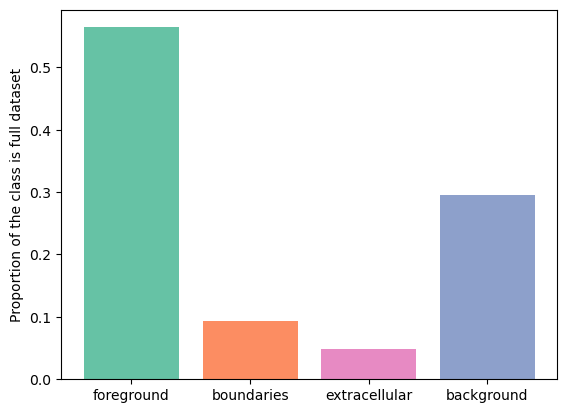

In [7]:
plt.figure()
for name, chan in channels.items():
    plt.bar(chan, label[chan].sum() / label[chan].size, tick_label=full_names[name], color=cols[name])
    print(f"{name}: {label[chan].sum() / label[chan].size:.2f}")
names = channels.keys()
plt.xticks([channels[name] for name in names], [full_names[name] for name in names]);
plt.ylabel("Proportion of the class is full dataset");

As we can see, boundaries class takes up $9$ % of the volume. Let's use `GridPatchDataset` to split the volume into a grid of non-overlapping tiles of size $128 \times 128 \times 128$ and check the distribution of the boundaries class. $128 \times 128 \times 128$ is a typical tile size for doing sliding window predictions with a relatively small network.

In [8]:
from monai.data import GridPatchDataset, DataLoader, PatchIterd
patch_iter = PatchIterd(keys=["image", "label"], patch_size=(128, 128, 128), start_pos=(0, 0, 0))
grid_dataset = GridPatchDataset(data=ds, patch_iter=patch_iter)
from tqdm import tqdm
class_distribution = {"fg": [], "boundaries": [], "extra": [], "bg": []}

for item in tqdm(DataLoader(grid_dataset, batch_size=1, num_workers=8)):
    item = item[0]
    img = item["image"].numpy()[0]
    lbl = item["label"].numpy()[0].astype(np.uint16)
    class_distribution["fg"].append(lbl[0].sum() / lbl[0].size)
    class_distribution["boundaries"].append(lbl[1].sum() / lbl[1].size)
    class_distribution["extra"].append(lbl[2].sum() / lbl[2].size)
    class_distribution["bg"].append(lbl[3].sum() / lbl[3].size)

1716it [01:09, 24.55it/s]


Text(0.5, 0, 'Proportion of boundary class in tiles')

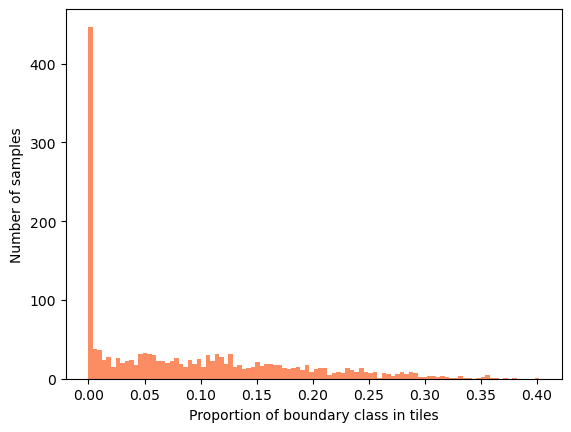

In [9]:
plt.hist(class_distribution["boundaries"], bins=100, color=cols["boundaries"])
plt.ylabel("Number of samples")
plt.xlabel("Proportion of boundary class in tiles")

Most of the samples have no boundary class and the rest of the samples are mostly far from the dataset-wide $9$%. This means that tiles have rather different content, potentially making mean and variance used in normalization layers also very different. How large do tiles need to be roughly stable at least in terms of the class proportions?

In [10]:
patch_sizes = [96, 128, 192, 256, 512]
boundary_proportions = []

for patch_size in patch_sizes:

    patch_iter = PatchIterd(keys=["image", "label"], patch_size=(patch_size, patch_size, patch_size), start_pos=(0, 0, 0))
    grid_dataset = GridPatchDataset(data=ds, patch_iter=patch_iter)
    from tqdm import tqdm
    class_distribution = {"fg": [], "boundaries": [], "extra": [], "bg": []}

    for item in tqdm(DataLoader(grid_dataset, batch_size=1, num_workers=8)):
        item = item[0]
        img = item["image"].numpy()[0]
        lbl = item["label"].numpy()[0].astype(np.uint16)
        class_distribution["fg"].append(lbl[0].sum() / lbl[0].size)
        class_distribution["boundaries"].append(lbl[1].sum() / lbl[1].size)
        class_distribution["extra"].append(lbl[2].sum() / lbl[2].size)
        class_distribution["bg"].append(lbl[3].sum() / lbl[3].size)

    boundary_proportions.append(class_distribution["boundaries"]);

4320it [01:12, 59.94it/s] 
1716it [01:08, 25.22it/s]
576it [01:25,  6.71it/s]
252it [01:40,  2.52it/s]
36it [03:08,  5.24s/it]


In [11]:
import seaborn as sns
import pandas as pd

long_df = pd.DataFrame(columns=["tile_size", "prop"])
for patch_size, prop in zip(patch_sizes, boundary_proportions):
    df =pd.DataFrame(data=prop, columns=["prop"])
    df["tile_size"] = patch_size
    long_df = pd.concat([long_df, df], ignore_index=True);
long_df["tile_size"] = long_df["tile_size"].astype(int)

/tmp/ipykernel_2986358/1492769951.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  long_df = pd.concat([long_df, df], ignore_index=True);


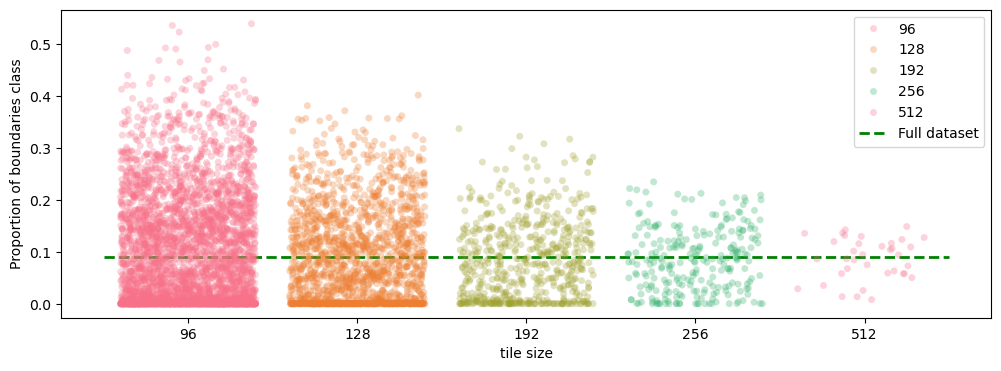

In [12]:
plt.figure(figsize=(12, 4))
sns.stripplot(long_df, x="tile_size", y="prop", hue="tile_size", jitter=0.4, alpha=0.3, palette="husl")
plt.hlines(0.09, xmin=-0.5, xmax=len(patch_sizes)-0.5, color="green", linestyle="--", linewidth=2, label="Full dataset")
plt.xlabel("tile size")
plt.ylabel("Proportion of boundaries class");
plt.legend();

As we can see, even with a very large tile size of $512 \times 512 \times 512$, which, by the way, is unrealistic for the GPU RAM even with `batch_size=1`, the boundary class proportion significantly strays from the volume-wise $9$%. This means that the tile-wise feature statistics will vary a lot from tile to tile. In the sliding window inference the tiling is often done with overlap to compensate for the incomplete convolutions on the tile borders. However, due to tile-wise normalization inside the network predictions **for the exact same pixel** in neighboring tiles can be completely different even in the central part of the tile where all convolutions are valid.

## Feature normalization depends on tile content

I trained a 3D U-Net to segment the electron microscopy volume introduced earlier. This model uses $InstanceNorm$:

In [13]:
from monai.utils import set_determinism
from monai.data import DataLoader, PatchDataset
from monai.transforms import RandSpatialCropSamplesd

import torch
from no_tiling.models import load_model

from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor


In [14]:
model_path = "data/experiments/organoids_boundaries/setup_03/model_epoch_0049.pth"

# Monai settings
set_determinism(seed=0)

# Set device
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device(6)
else:
    print("GPU is not available")
    device = torch.device("cpu")

# Load model    
model = load_model(model_path).to(device)
model.eval()
print(model)

GPU is available
BasicUNet features: (32, 64, 128, 32).
Scaling factors: [[2, 2, 2], [2, 2, 2]]
UNet(
  (conv_0): TwoConv(
    (conv_0): Convolution(
      (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(32, eps=1e-05, momentum=0.01, affine=False, track_running_stats=False)
        (D): Dropout3d(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (conv_1): Convolution(
      (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(32, eps=1e-05, momentum=0.01, affine=False, track_running_stats=False)
        (D): Dropout3d(p=0.0, inplace=False)
        (A): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
  )
  (downs): ModuleList(
    (0): Down(
      (max_pooling): MaxPool3d(kernel_size=[2, 2, 2], stride=[2, 2, 2], padding=0, dilation=1, ceil_mode=False)
      (convs): TwoConv(
  

We can directly check how tile content affects the features and predictions by sampling 4 overlapping tiles and examining the features and predictions at the exact same pixel.

In [15]:
image = ds[0]["image"]
label = ds[0]["label"]

In [16]:
gc = [200, 430, 180]
z_sh = 32
full_tile_sh = 192
margin = 40
tile_sh = full_tile_sh - margin

tile_1 = image[:, gc[0] - z_sh:gc[0] + z_sh, gc[1] - tile_sh: gc[1] + margin, gc[2] - tile_sh: gc[2] + margin]
tile_1_label = label[:, gc[0] - z_sh:gc[0] + z_sh, gc[1] - tile_sh: gc[1] + margin, gc[2] - tile_sh: gc[2] + margin]
tile_1_coord = [z_sh, tile_sh, tile_sh]

tile_2 = image[:, gc[0] - z_sh:gc[0] + z_sh, gc[1] - tile_sh: gc[1] + margin, gc[2] - margin: gc[2] + tile_sh]
tile_2_label = label[:, gc[0] - z_sh:gc[0] + z_sh, gc[1] - tile_sh: gc[1] + margin, gc[2] - margin: gc[2] + tile_sh]
tile_2_coord = [z_sh, tile_sh, margin]

tile_3 = image[:, gc[0] - z_sh:gc[0] + z_sh, gc[1] - margin: gc[1] + tile_sh, gc[2] - tile_sh: gc[2] + margin]
tile_3_label = label[:, gc[0] - z_sh:gc[0] + z_sh, gc[1] - margin: gc[1] + tile_sh, gc[2] - tile_sh: gc[2] + margin]
tile_3_coord = [z_sh, margin, tile_sh]

tile_4 = image[:, gc[0] - z_sh:gc[0] + z_sh, gc[1] - margin: gc[1] + tile_sh, gc[2] - margin: gc[2] + tile_sh]
tile_4_label = label[:, gc[0] - z_sh:gc[0] + z_sh, gc[1] - margin: gc[1] + tile_sh, gc[2] - margin: gc[2] + tile_sh]
tile_4_coord = [z_sh, margin, margin]



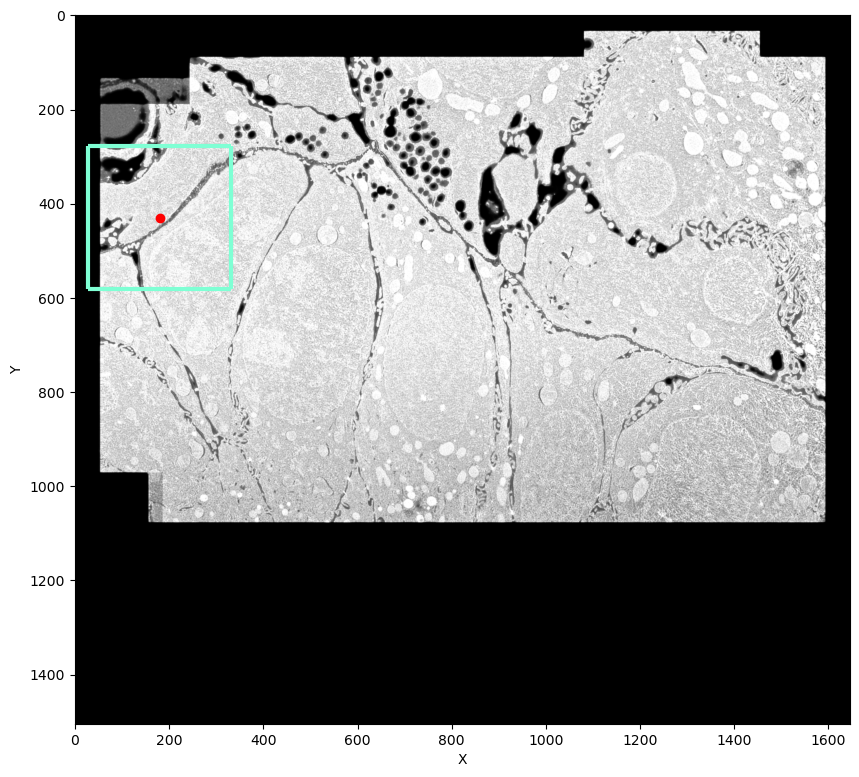

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(image[0, gc[0], :, :], cmap="Greys_r")
plt.scatter(gc[2], gc[1], color="red")
plt.vlines([gc[2] - tile_sh, gc[2] + tile_sh], ymin=gc[1] - tile_sh, ymax=gc[1] + tile_sh, linewidth=3, color="aquamarine")
plt.hlines([gc[1] - tile_sh, gc[1] + tile_sh], xmin=gc[2] - tile_sh, xmax=gc[2] + tile_sh, linewidth=3, color="aquamarine")
plt.xlabel("X")
plt.ylabel("Y");

Here red dot shows the pixel that we are going to examine. I'm going to split the area highlighted with a square into 4 overlapping tiles. In this case the neighboring tiles have quite different class distributions: upper left tile has more extracellular matrix and outside-of-image background while tile lower right tile is mostly inside one cell, with most of the pixels having foreground class:

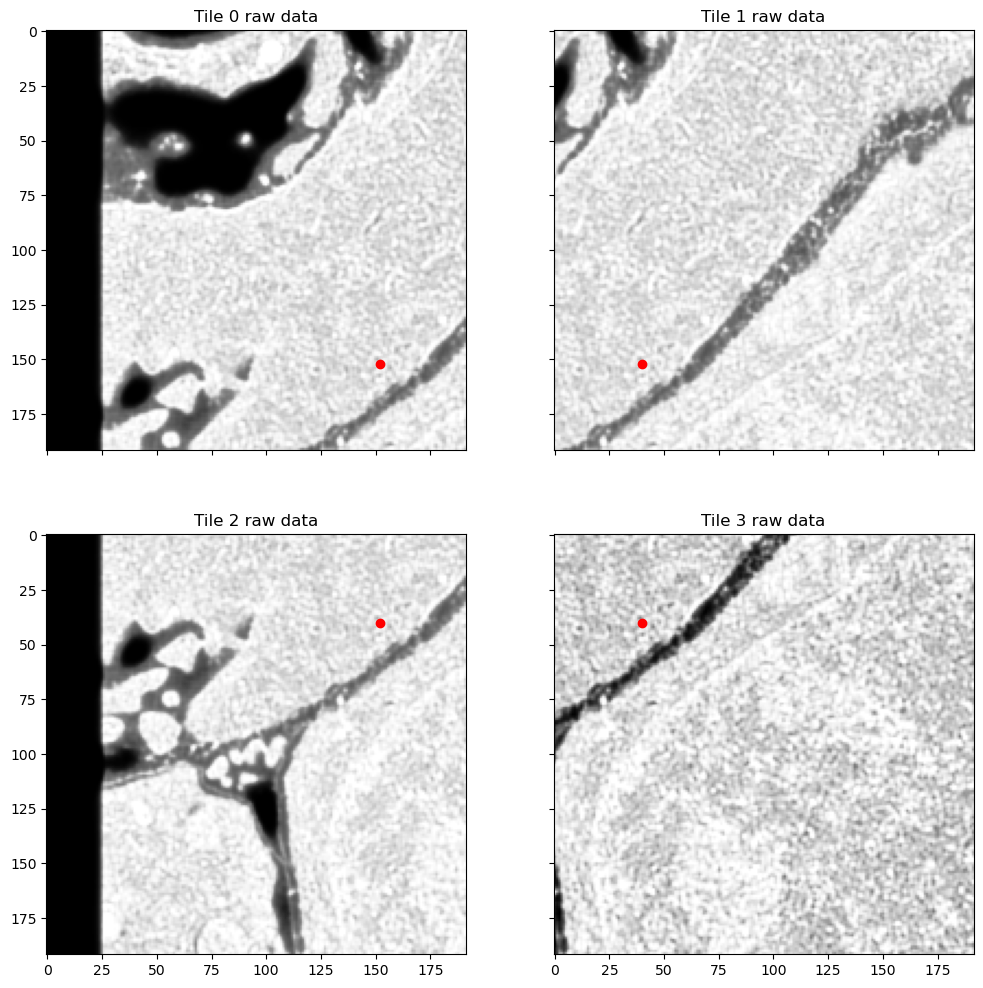

<Figure size 640x480 with 0 Axes>

In [18]:
f, axes = plt.subplots(2, 2,  sharex=True, sharey=True, figsize=(12, 12))

for tile, label, coord, ax, idx in zip([tile_1, tile_2, tile_3, tile_4], [tile_1_label, tile_2_label, tile_3_label, tile_4_label], [tile_1_coord, tile_2_coord, tile_3_coord, tile_4_coord], axes.flat, range(4)):
    ax.imshow(tile[0, z_sh], cmap="Greys_r")
    ax.scatter([coord[2]], [coord[1]], color="red")
    ax.set_title(f"Tile {idx} raw data")
    
plt.show();
plt.tight_layout();


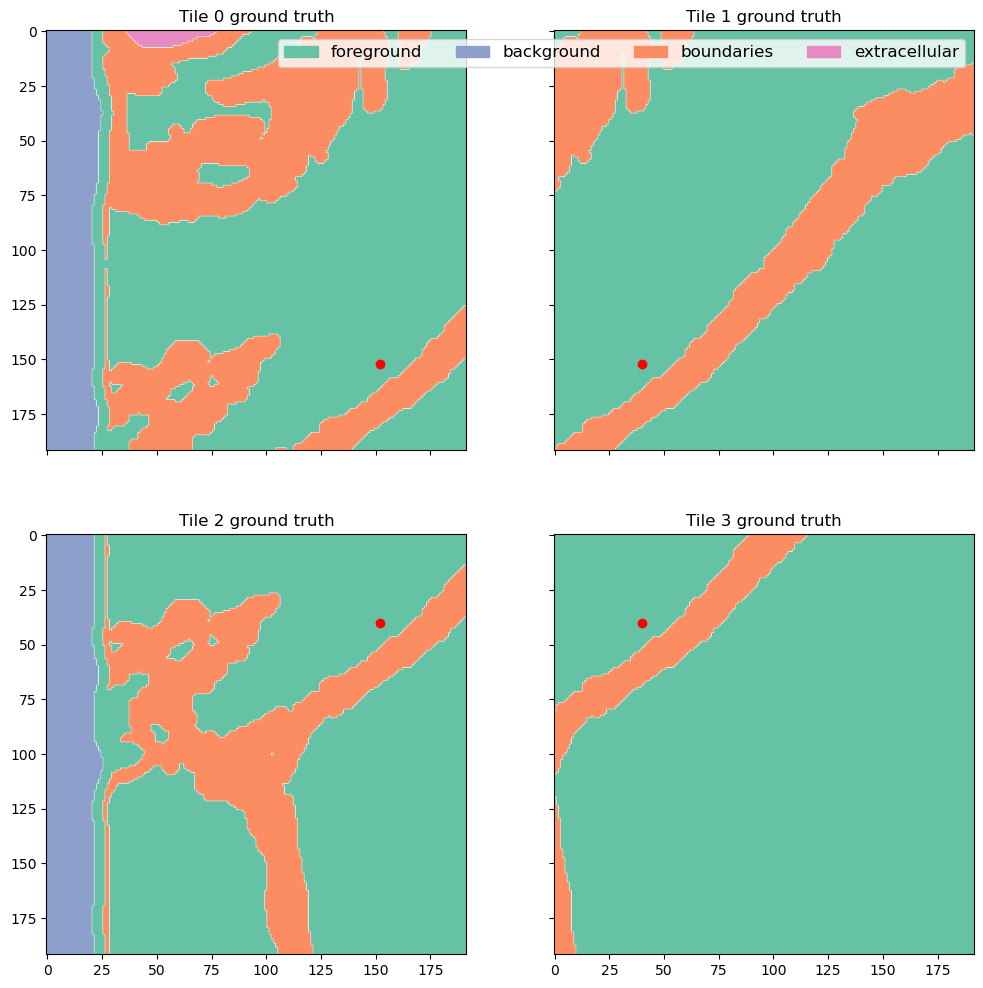

<Figure size 640x480 with 0 Axes>

In [19]:
f, axes = plt.subplots(2, 2,  sharex=True, sharey=True, figsize=(12, 12))

for tile, label, coord, ax, idx in zip([tile_1, tile_2, tile_3, tile_4], [tile_1_label, tile_2_label, tile_3_label, tile_4_label], [tile_1_coord, tile_2_coord, tile_3_coord, tile_4_coord], axes.flat, range(4)):
    # ax.imshow(tile[0, z_sh], cmap="Greys_r")
    legend_patches = []
    for name, chan in channels.items():
        cmap = colors.ListedColormap(['white', cols[name]])
        ax.imshow(label[chan, z_sh], label=name, cmap=cmap, alpha=(label[chan, z_sh] > 0).astype(float))
        legend_patches.append(mpatches.Patch(color=cols[name], label=full_names[name]))
    ax.scatter([coord[2]], [coord[1]], color="red")
    ax.set_title(f"Tile {idx} ground truth")
    
axes[0, 1].legend(handles=legend_patches, fontsize="large", ncol=4)
plt.show();
plt.tight_layout();

The network starts with the convolution `conv_0` followed by a normalization layer and nonlinearity. I extracted the outputs of the very first convolution and the subsequent normalization layer for the pixel of interest. Since it is exactly the same pixel with the same immediate context, in principle it should also have the same or very similar features inside the network regardless of how the tiling was done, right?

In [20]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
nodes, _ = get_graph_node_names(model)
print(nodes)

['x', 'conv_0.conv_0.conv', 'conv_0.conv_0.adn.N', 'conv_0.conv_0.adn.D', 'conv_0.conv_0.adn.A', 'conv_0.conv_1.conv', 'conv_0.conv_1.adn.N', 'conv_0.conv_1.adn.D', 'conv_0.conv_1.adn.A', 'downs.0.max_pooling', 'downs.0.convs.conv_0.conv', 'downs.0.convs.conv_0.adn.N', 'downs.0.convs.conv_0.adn.D', 'downs.0.convs.conv_0.adn.A', 'downs.0.convs.conv_1.conv', 'downs.0.convs.conv_1.adn.N', 'downs.0.convs.conv_1.adn.D', 'downs.0.convs.conv_1.adn.A', 'downs.1.max_pooling', 'downs.1.convs.conv_0.conv', 'downs.1.convs.conv_0.adn.N', 'downs.1.convs.conv_0.adn.D', 'downs.1.convs.conv_0.adn.A', 'downs.1.convs.conv_1.conv', 'downs.1.convs.conv_1.adn.N', 'downs.1.convs.conv_1.adn.D', 'downs.1.convs.conv_1.adn.A', 'upcats.0.upsample.deconv', 'upcats.0.convs.conv_0.conv', 'upcats.0.convs.conv_0.adn.N', 'upcats.0.convs.conv_0.adn.D', 'upcats.0.convs.conv_0.adn.A', 'upcats.0.convs.conv_1.conv', 'upcats.0.convs.conv_1.adn.N', 'upcats.0.convs.conv_1.adn.D', 'upcats.0.convs.conv_1.adn.A', 'upcats.1.upsamp

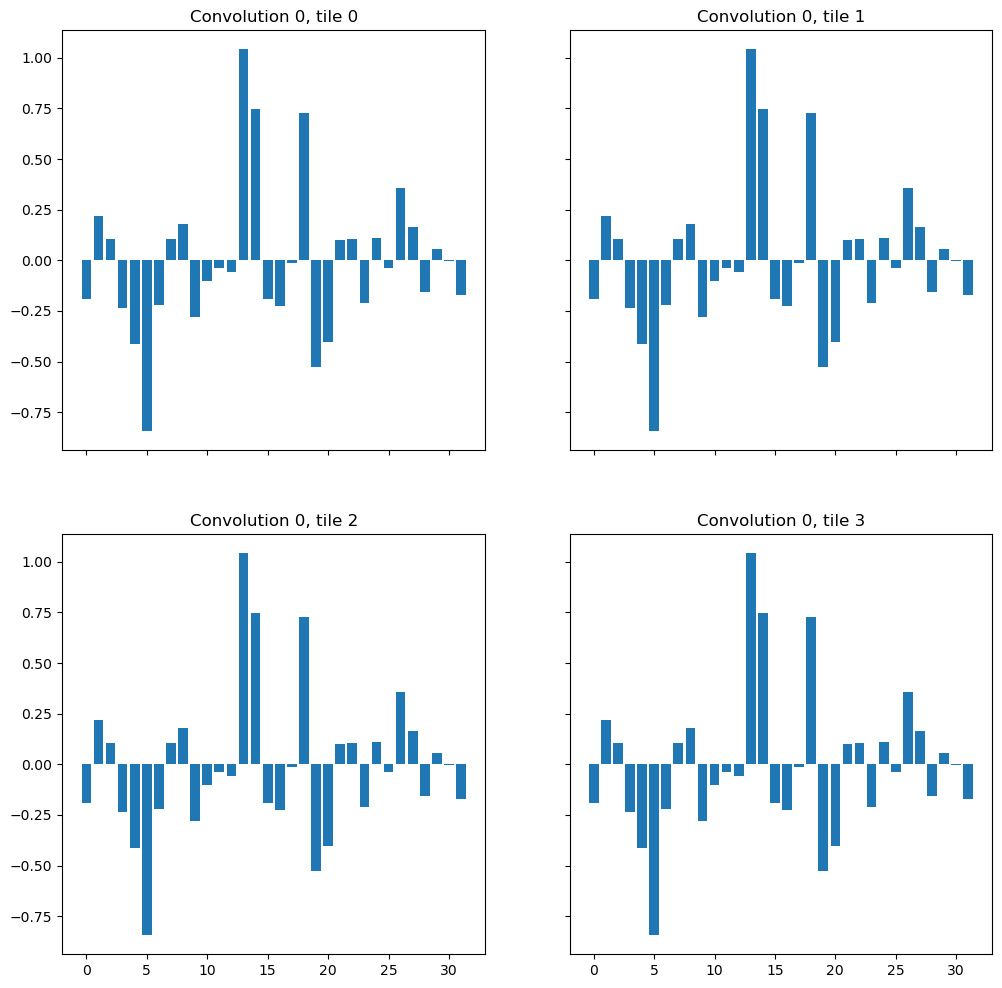

In [21]:
feature_extractor = create_feature_extractor(
model, return_nodes=['conv_0.conv_0.conv', 'conv_0.conv_0.adn.N'])

conv_features = []
norm_features = []
prediction = []

f, axes = plt.subplots(2, 2,  sharex=True, sharey=True, figsize=(12, 12))

for tile, coord, ax, idx in zip([tile_1, tile_2, tile_3, tile_4], [tile_1_coord, tile_2_coord, tile_3_coord, tile_4_coord], axes.flat, range(4)):
    out = feature_extractor(tile[None, ...].to(device))
    conv_feat = out['conv_0.conv_0.conv'].detach().to("cpu")
    norm_feat = out['conv_0.conv_0.adn.N'].detach().to("cpu")
    
    ax.bar(range(conv_feat.shape[1]), conv_feat[0, :, coord[0], coord[1], coord[2]])
    ax.set_title(f"Convolution 0, tile {idx}")

    
    conv_features.append(conv_feat[0, :, coord[0], coord[1], coord[2]])
    norm_features.append(norm_feat[0, :, coord[0], coord[1], coord[2]])

As expected, the output of the first convolution layer is exactly the same for the target pixel, regardless of the tile.

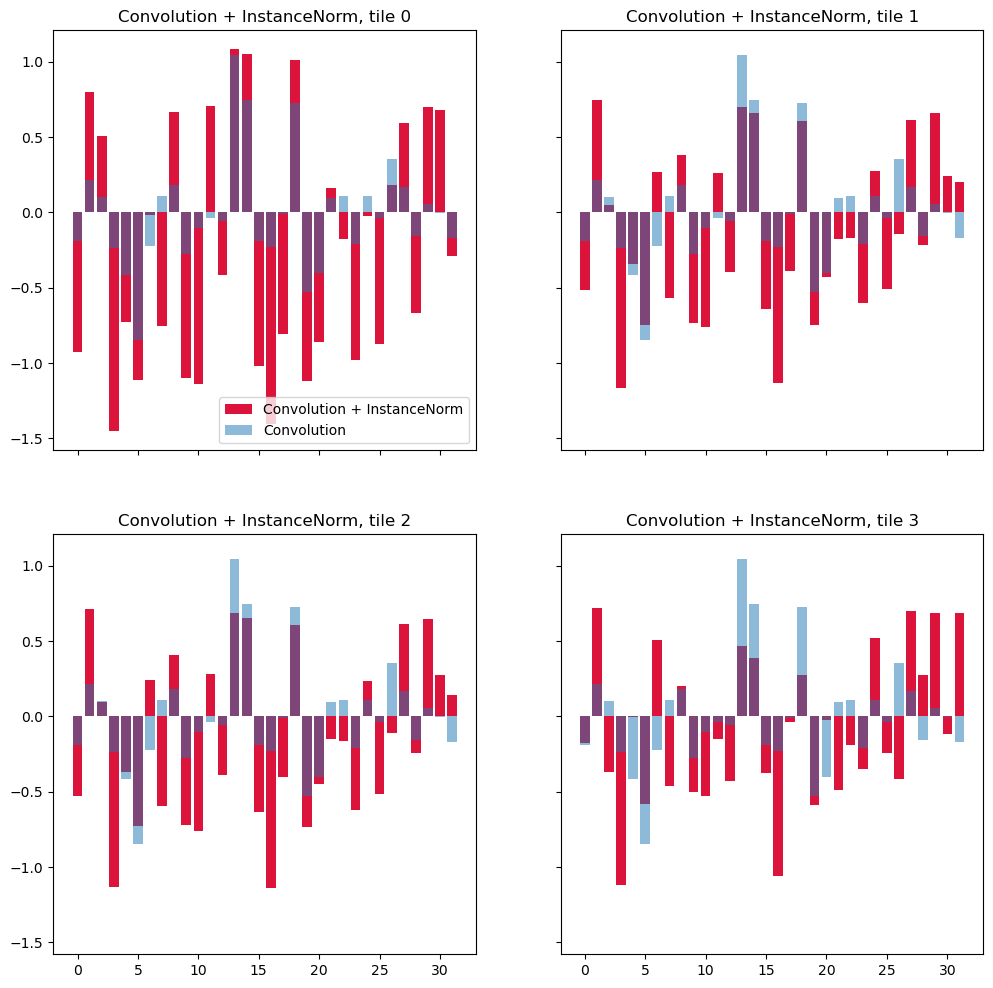

In [22]:
f, axes = plt.subplots(2, 2,  sharex=True, sharey=True, figsize=(12, 12))

for tile, coord, ax, idx in zip([tile_1, tile_2, tile_3, tile_4], [tile_1_coord, tile_2_coord, tile_3_coord, tile_4_coord], axes.flat, range(4)):
    norm_feat = norm_features[idx]
    conv_feat = conv_features[idx]
    
    ax.bar(range(len(norm_feat)), norm_feat, color="crimson", label="Convolution + InstanceNorm")
    ax.bar(range(len(conv_feat)), conv_feat, alpha=0.5, label="Convolution")
    ax.set_title(f"Convolution + InstanceNorm, tile {idx}")

axes[0, 0].legend()

On this plot feature after the first convolution layer are shown in transparent blue and features after normalization - in red. After normalization the features for the same pixel become different, depending on which tile it belongs to. Distributions in tile 1 and tile 3 are more or less similar because the content of these tiles is more similar, however, even between them there's a significant difference. 

Class probabilities at target pixel in tile 0
[9.9999976e-01 6.6844350e-08 3.7892136e-08 6.6073149e-08]
Class probabilities at target pixel in tile 1
[9.9873453e-01 6.2038205e-05 1.8355773e-04 1.0198853e-03]
Class probabilities at target pixel in tile 2
[9.9901414e-01 3.3465363e-05 9.1410409e-05 8.6091616e-04]
Class probabilities at target pixel in tile 3
[9.9947053e-01 9.7691009e-05 1.9195935e-04 2.3982450e-04]


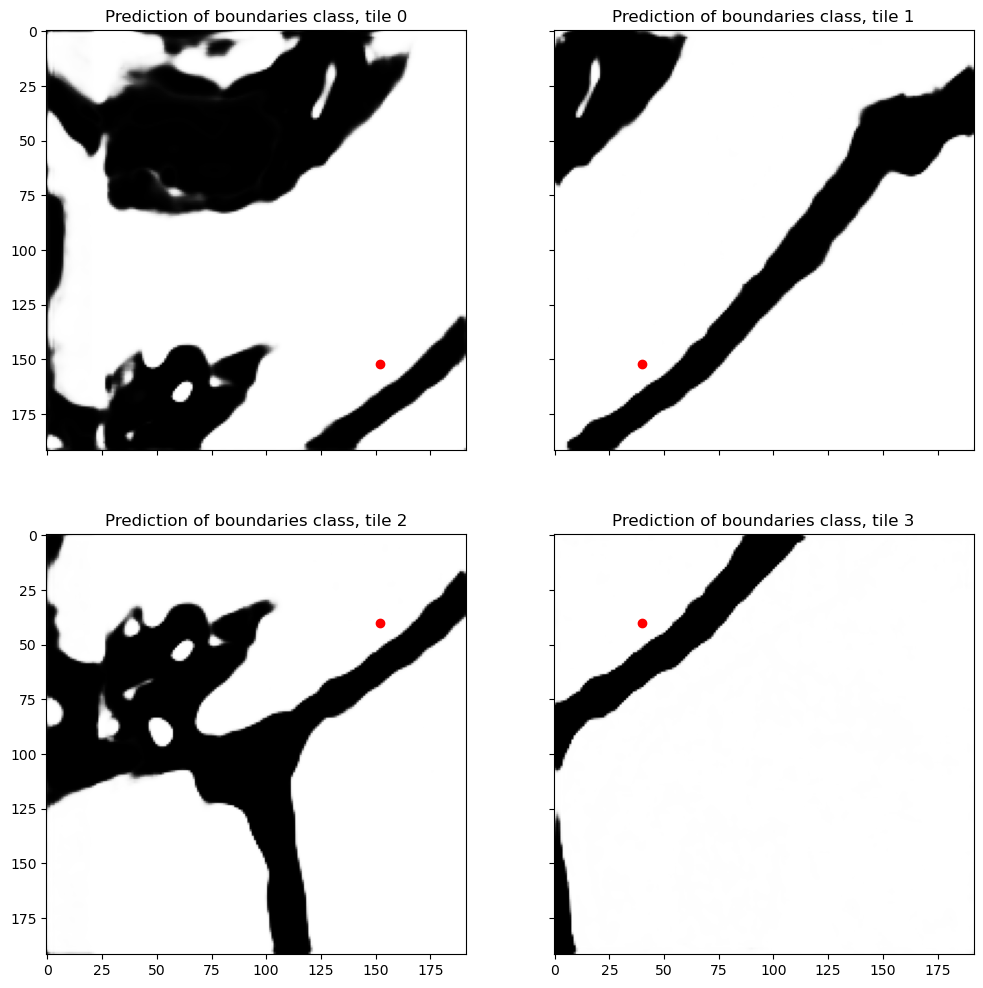

In [23]:
f, axes = plt.subplots(2, 2,  sharex=True, sharey=True, figsize=(12, 12))

for tile, coord, ax, idx in zip([tile_1, tile_2, tile_3, tile_4], [tile_1_coord, tile_2_coord, tile_3_coord, tile_4_coord], axes.flat, range(4)):
    out = model(tile[None, ...].to(device)).detach().to("cpu").numpy()
    ax.imshow(out[0, 0, z_sh], cmap="Greys_r")
    ax.scatter([coord[2]], [coord[1]], color="red")
    print(f"Class probabilities at target pixel in tile {idx}")
    print(out[0, :, z_sh, coord[1], coord[2]])
    ax.set_title(f"Prediction of boundaries class, tile {idx}")

Difference in normalized features leads to the differences in final predictions. In this particular case the difference was not big enough to flip the most probable class for this pixel, but still the predictions do not match exactly anymore. 0.01 might be imperceptible for a person but I promise that watershed will pick up on it in the most annoying way! Besides, if we compare other areas, we can see that some pixels which are confidently predicted as boundary in one tile can change completely to a different class in another tile.

## Prediction quality depends on tile size

The size of tiles defines how stable the normalization statistics are and therefore how well the predictions match between tiles. Running prediction with different tile sizes highlights the problem and gives another confirmation that the visible tiles are not an artifact of data acquisition. 
I run predictions with the following tile sizes:   
$96 \times 96 \times 96$  
$96 \times 128 \times 128$  
$96 \times 256 \times 256$ 

Note that there's an overlap of $32$ pixels between tiles in each direction and then the predictions in the $32$ pixels halo are multiplied by $0$. This way only valid areas of each tile are used in the stitched prediction. For example, for $96 \times 96 \times 96$ tile only the central area of $32 \times 32 \times 32$ is used in the final stitched volume. In this setup there's no averaging between predictions from neighbouring tiles.

In [24]:
from monai.inferers import sliding_window_inference

In [25]:
image = ds[0]["image"]
z_pos = image.shape[1] // 2
inference_slice = image[None, :, z_pos - 48:z_pos + 48, ...]

In [26]:
tile_sizes = [96, 128, 256]
tile_size_predictions = []

for tile_size in tile_sizes:
    roi_size=(96, tile_size, tile_size)
    print(f"Predict using tile shape {roi_size}")
    halo=(32, 32, 32)
    sw_batch_size=1
    roi_weight_map = np.zeros(roi_size)
    roi_weight_map[halo[0]:-halo[0], halo[1]:-halo[1], halo[2]:-halo[2]] = 1
    overlap = max(*halo) * 2 / max(*roi_size)
    print("Overlap: ", overlap)
    with torch.no_grad():
        prediction = sliding_window_inference(inference_slice, roi_size, sw_batch_size, model, progress=True, sw_device=torch.device(6), device="cpu", roi_weight_map=roi_weight_map, overlap=overlap)
        prediction = prediction.detach().to("cpu")
    tile_size_predictions.append(prediction)

Predict using tile shape (96, 96, 96)
Overlap:  0.6666666666666666


  1%|          | 13/2300 [00:01<02:13, 17.16it/s]

100%|██████████| 2300/2300 [01:45<00:00, 21.76it/s]


Predict using tile shape (96, 128, 128)
Overlap:  0.5


100%|██████████| 575/575 [00:45<00:00, 12.70it/s]


Predict using tile shape (96, 256, 256)
Overlap:  0.25


100%|██████████| 72/72 [00:20<00:00,  3.59it/s]


In [27]:
prediction = prediction.detach().to("cpu")

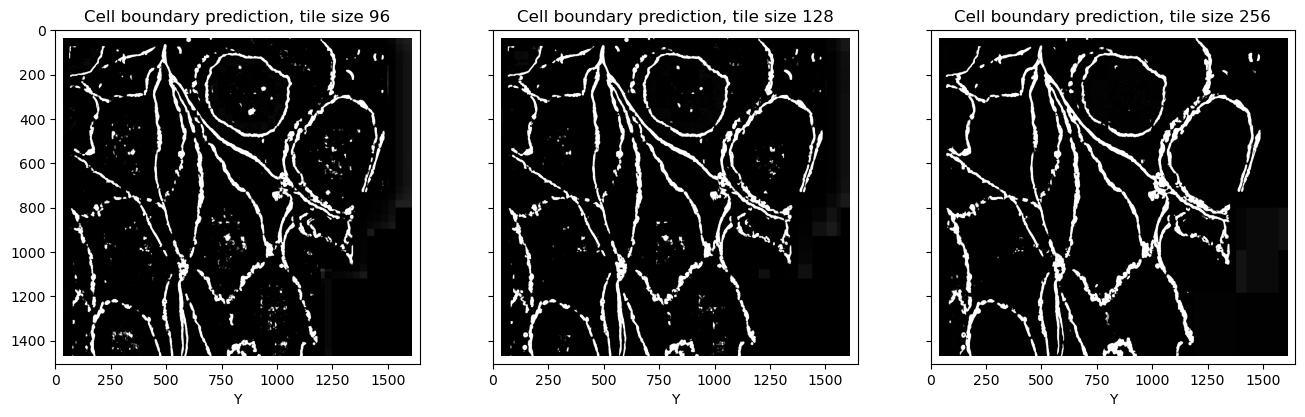

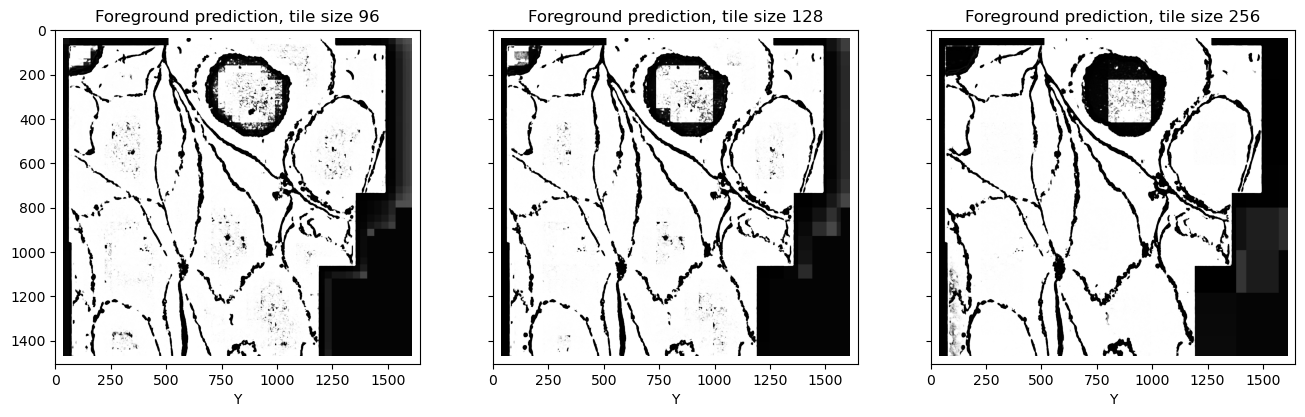

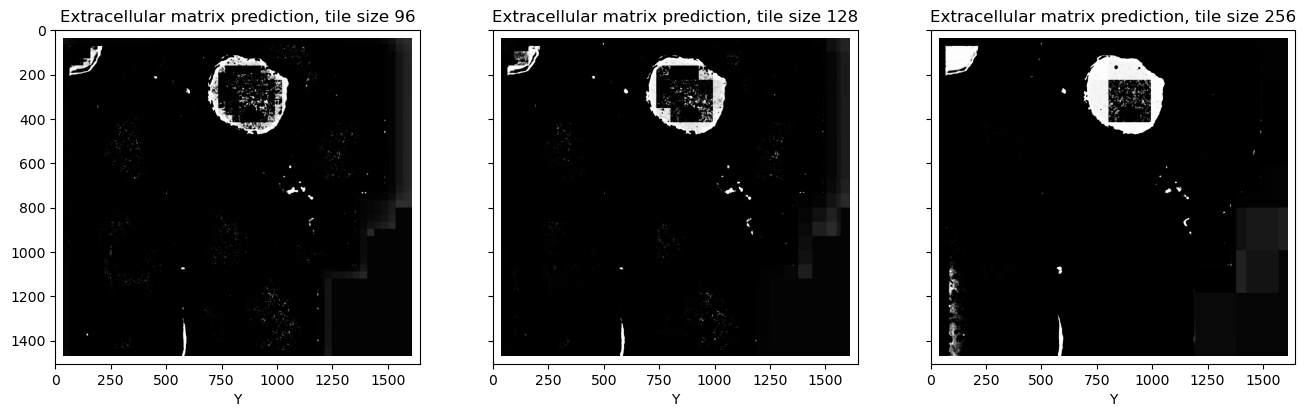

In [28]:
f, axes = plt.subplots(1, 3,  sharex=True, sharey=True, figsize=(16, 5))
for tile_size, prediction, ax in zip(tile_sizes, tile_size_predictions, axes.flat):
    ax.imshow(prediction[0, 1, 48], cmap="Greys_r")
    ax.set_xlabel("X")
    ax.set_xlabel("Y")
    ax.set_title(f"Cell boundary prediction, tile size {tile_size}")
plt.show()

f, axes = plt.subplots(1, 3,  sharex=True, sharey=True, figsize=(16, 5))
for tile_size, prediction, ax in zip(tile_sizes, tile_size_predictions, axes.flat):
    ax.imshow(prediction[0, 0, 48], cmap="Greys_r")
    ax.set_xlabel("X")
    ax.set_xlabel("Y")
    ax.set_title(f"Foreground prediction, tile size {tile_size}")
plt.show()

f, axes = plt.subplots(1, 3,  sharex=True, sharey=True, figsize=(16, 5))
for tile_size, prediction, ax in zip(tile_sizes, tile_size_predictions, axes.flat):
    ax.imshow(prediction[0, 2, 48], cmap="Greys_r")
    ax.set_xlabel("X")
    ax.set_xlabel("Y")
    ax.set_title(f"Extracellular matrix prediction, tile size {tile_size}")
plt.show()

Inspecting the predictions, we can note a few things:

- **The performance very obviously depends on the tile size.** Also there are clear squares, size of which corresponds to the chosen tile size minus halo. This is kind of embarrassing? At the time of writing, it's end of 2025, GenAI is putting artists, creative writers and python developers out of jobs, technological singularity is quickly approaching, etc etc, and yet, what's this?? I feel kind of insecure posting these ugly predictions on the internet. Maybe I should just smooth out the tile edges somehow before presenting this and pretend it's fine... Oh wait, too late...

- Mismatch is not limited to the edges of the tiles. In fact, the edges (32 pixels wide) were removed before stitching. Tiling artifacts affect the entire tile.

- It's not a slight difference. Looking closely at the extracellular matrix predictions, especially at the larger tile size, we can notice that this class is predicted correctly in the tiles which contain both foreground and extracellular matrix, but then if the tile entirely consists only of extracellular matrix, it is suddenly wrongly predicted as foreground. The same can be seen in the middle of the cells: if a tile fits completely inside the cell and there are no cell boundaries for the context, normalization becomes wrong.


## Global feature normalization eliminates tiling artifacts

The problems with stitching are caused by the feature normalization inside the network, so, to get rid of the tiling artifacts, a normalization that uses the same parameters for all the tiles should be used. $BatchNorm$, another popular normalization layer, is doing just that. During training $BatchNorm$ uses statistics of the current batch and collects a running average. During inference it uses saved running average. Although running mean and variance are not learned in a sense that there's no gradient descent with respect to these parameters, they are estimated from the training data. With the normalization parameters fixed, the predictions can match exactly.

Running predictions with different tile size shows that for $InstanceNorm$ the prediction quality depends on the tile size. Once the tile size is large enough that most tiles become more or less representative of the full dataset, the prediction quality reaches plato. For a network with global feature normalization the prediction quality remains the same regardless of the tile size.

<img src="images/dice_vs_tilesize.png" alt="Sliding window inference" align=center style="width: 400px;"/>

## Receptive field and halo

Neural networks used for segmentation take images as input and produce images, usually of the same size, as output. The value assigned by the network to each pixel of the output is a deterministic function of a certain set of pixels in the input. This area of the input that affects one pixel in the output is called receptive field. There are many papers and tutorials describing how to calculate its size theoretically, based on the convolution filter sizes and strides. I have to admit that I never managed to apply these formulas correctly, somehow there's always an extra convolution layer or something... 

Fortunately, we can just use backpropagation to calculate theoretical and real receptive field. For that we run predictions with the network as usual and then calculate the gradient of the prediction in the central pixel **with respect to the input image** (not the network parameters like we do during training). The area of input where the gradients are not `None` is the theoretical receptive field and the area where the gradients are large is the effective receptive field. The gradient measurement from just one tile can be noisy so the gradients are calculated for all the tiles in the dataset and then averaged.

Let's compare the receptive field for to networks with the same architecture, except one has `BatchNorm` (global feature normalization) and the other - `InstanceNorm` (tile-wise feature normalization).

<img src="images/receptive_field_comparison.png" alt="Receptive field comparison" align=center style="width: 800px;"/>

U-Net with global feature normalization has the receptive field that I would expect upon reading about receptive fields of CNNs in general. There is a limited area around the target pixel - in this case, a square with a side of 44 pixels - which takes part in the calculation of the final prediction in the central pixel of the output. Within this area the gradients have roughly gaussian distribution, with the relative contribution of pixels to the prediction falling for pixels which are further away from the center of the image. For this network only the content of the receptive field matters, making it possible to seamlessly stitch predictions as long as the 22 pixels on the edge of each tile are removed due to incomplete context.

U-Net with tile-wise feature normalization has the same effective receptive field, determined by the number of layers and parameters of the convolution layers. However, its full receptive field is not limited and takes up the whole tile, as through the normalization parameter calculation every pixel takes part in the final prediction. This network's predictions can't be used to obtain seamless stitched predictions regardless of how large the overlap between tiles is.

## Transformers inherently cause tiling artifacts

For the convolutional architecture full inference pipeline for the large image is the following:

- Split the large image into tiles of arbitrary size
- Run prediction with features inside the network normalized either using statistics of the input tile or global fixed parameters
- Stitch the predictions for individual tiles to obtain final prediction for the large image


For Transformers the procedure is more complicated:

- Split the large image into tiles of fixed size defined by Transformer architecture, in particular, by the positional encoding
- Split the tile into patches, often $16 \times 16$ is used
- Encode each patch, normalize features **per patch** using `GroupNorm`
- Calculate new features of each patch using features of all patches and attention mechanism, normalize features **per patch** using `GroupNorm`, repeat this step multiple times
- Use final features to generate dense prediction
- Stitch the predictions for individual tiles to obtain final prediction for the large image

In this case the whole tile is always used for the prediction of every pixel of the output. Normally the selling point of transformer architecture: less bias, more context used, but in the sliding window inference context it means that it's not possible to achieve seamless stitching. Moreover, since there's a second round of tiling/stitching inside the transformer, dense predictions even inside one tile are not necessarily smooth - for more details see the numerous works on the registers and high-norm patches in DINOv2. 

The same receptive field calculation as we did for the U-Net, shows the clear patch artifacts in the Transformer-based UNETR. Interestingly, the effective receptive field is not larger than for the usual U-Net:

<img src="images/receptive_field_unetr.png" alt="Receptive field UNETR" align=center style="width: 400px;"/>

In transformers theoretical receptive field is the whole tile, so mismatch between tiles is not an edge artifact but rather the inherent property of the network arising from the attention mechanism and patch-wise normalization.

## Tile mismatch metric

<img src="images/tile_mismatch_metric.png" alt="Receptive field UNETR" align=center style="width: 400px;"/>

Quantification of tiling artifacts is challenging because their magnitude depends on the similarity of the content of neighboring tiles in different parts of the image. To figure out if there's tiling mismatch, split the image into overlapping tiles and compare the predictions in the overlap areas. To avoid edge effects, only take the valid part of the overlap, as shown in the picture above. To catch all possible issues, run the predictions for the whole dataset in a way that valid overlap areas cover the whole image or at least some representative part of it.

I found it useful to calculate two metrics: **maximum distance** and **median tile mismatch**.

Maximum distance is the maximum difference between predictions.
$$
max\ dist = \max_{i=1}^M(|O_{i1} - O_{i2}|),
$$

where $O_{i1}$ and $O_{i2}$ are predictions in the valid overlap region in tile $i$ and $M$ is number of sampled tiles. In $max\ dist$ $\max$ is taken over all channels and all tiles, making it an indicator of whether given setup produces tiling artifacts. If $max\ dist = 0$ the predictions match perfectly and the pipeline is fully artifact-free. Although this metric is good for detecting the presence of artifacts, I found that in almost all cases the maximum difference was not very descriptive of how bad the artifacts are on average. For example, in our previous experiment with different tile sizes, prediction with $96 \times 96 \times 96$ obviously had worse tiling artifacts than $96 \times 128 \times 128$. Maximum distance in both cases is 1 as there are clearly pixels that completely change the class but on average we see less artifacts.

To quantify how bad the artifacts are I found it useful to look at the median distance between predictions over all tiles:

$$
tile\ mismatch = \mathop{\mathit{median}}_{i=1}^{M}(1 - Dice(O_{i1}, O_{i2})), 
$$


$Tile\ mismatch$ is calculated per channel and characterizes the magnitude of the artifacts. It is likely that in a large dataset there are neighboring tiles with similar content which have very similar predictions in the overlapping areas and then there are some tiles where the content of the image changes suddenly, causing much stronger artifacts. Calculating median roughly describes how bad the artifacts are in the image overall.

## Practical tips

### How to detect tiling artifacts?

- Run sliding window inference prediction pipeline with different tile sizes and different tile overlaps. If predictions change - there is something going on
- Run predictions for the tiles with large overlap and calculate the **maximum distance** between predictions. It should be exactly 0.

### How to eliminate tiling artifacts?

Once it's established that there is an issues with tiling and stitching, the question is which part of the pipeline causes them.

#### Preprocessing

After the large image is split into tiles, some pipelines apply transforms to tiles separately. For example, it is relatively common to apply normalize input intensity distribution for each tile separately, changing the input of the network in tile-dependent manner. Of course, this causes tiling artifacts. You can think of it the following way: if even the network input can't be stitched back seamlessly, why would the output have artifact-free?

**No tile-wise transforms should be applied to the input data**

#### Feature normalization inside the network
As we have seen in this tutorial, convolutional networks which normalize features based on the current input rather than global fixed parameters, cause mismatch between predictions. Unfortunately, it's not possible to easily switch between `InstanceNorm` and `BatchNorm`, so the only way is to train another network. Of course, there are many different architectures and layers, and a simple replacement of a normalization layer might not be enough for more sophisticated. No matter the architecture, the following principle hold:   

**All network parameters should be global and independent of the current input**

Of course, it applies only to networks which are translation-invariant. For examples, transformers always use the whole input image to generate predictions, so it is not possible to avoid artifacts.

#### Tile overlap

When the network is applied to the tiles, usually zero-padding or mirroring is used to keep the output same size as input. The predictions on the edge of the tiles will not match between neighboring tiles because the network does not get correct full context: part of the input is replaced with zeros. The size of affected area is determined by the theoretical receptive field of the network. Removing this affected area ensures that the predictions don't have any edge effects and should match.

**Only valid part of the prediction should be used for stitching**


#### Postprocessing
Same as with preprocessing, there should be no tile-wise postprocessing. 

**No tile-wise transforms should be applied to the output**

#### Consider the whole pipeline
If the pipeline has tiling artifacts, it is likely that the problem is not just in one part of the pipeline. For example, if the network creates artifacts, postprocessing might be set up to reduce them. Maybe the predicted probabilities are additionally normalized to reduce mismatch - then after fixing the problems with the network this postprocessing is likely to make the predictions worse. If after fixing one step the artifacts don't go away or get worse - it just means that there were multiple causes for them. Try to isolate parts:
- stitch the preprocessed inputs by replacing the network with an `Identity` layer
- run the network on the overlapping tile which were created manually, not by your normal sampling pipeline

Bioimage analysis is a diverse field and I couldn't possible anticipate all the fun/weird things people do to their images, however if the network is translation-invariant and none of its parameters depend on the current input, it generally should be possible to achieve seamless predictions for the images of arbitrary size. 

### How to minimize tiling artifacts?

Let's say the network which causes tiling artifacts is fixed and can't be retrained or you decided to use transformer architecture. How to make sure that there are as little artifacts as possible?

- Calculate effective receptive field and set the halo to a reasonable value. For example, for the UNETR used in this tutorial, we can see that only a few central tiles have a strong influence on the prediction, therefore `32` pixels is a good halo size.

- Adjust tile sampling to make sure that the content of all tiles is similar. Usually it means using `batch_size=1` and as large tile size as possible. Try to crop as much background as possible. 

- If, despite all efforts, there are still visible borders between tiles, try to apply smoothing when stitching. For example, nnU-Net and Cellpose compute weighted average of the tiles, with the weight decreasing from 1 in the middle of the tile to 0 at the border, so even if there's mismatch, it's not so obvious.

## Why use `InstanceNorm` at all?

If `InstanceNorm` causes all these problems, why does anyone use it at all? For detailed answer, check out my [tutorial on `BatchNorm`](https://buglakova.github.io/train-eval-disparity/).

For examples of different modalities, architectures and quantitative results check out my manuscript [Tiling artifacts and trade-offs of feature normalization in the segmentation of large biological images](https://arxiv.org/abs/2503.19545).